<a href="https://colab.research.google.com/github/lmencisoe/seguros/blob/main/Modelo_seguros_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from pandas_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import joblib
from xgboost import plot_importance
from google.colab import drive
drive.mount('/content/drive')
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Lectura de datos**

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/lmencisoe/seguros/main/seguros_database.csv",sep=";")

In [3]:
df

,ACTECON,GRUANALI,antigüedad,TAMAEMP,nrotrab,riesgo,categoria,target,modular,prom_antes,cant_antes
0,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__1,0.000000,0
1,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,1457.843500,1
2,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,0.000000,0
3,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,2892.159467,2
4,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
13963,ACT_ECON_5,GRU_AN_13,10,TAMA__2,91,RIESGO__3,CATEGORIA__0,3,MODULAR__0,6807.300000,1
13964,ACT_ECON_33,GRU_AN_9,7,TAMA__2,440,RIESGO__2,CATEGORIA__6,1,MODULAR__0,191.473800,1
13965,ACT_ECON_12,GRU_AN_4,15,TAMA__2,37,RIESGO__3,CATEGORIA__4,2,MODULAR__0,302.441133,2
13966,ACT_ECON_5,GRU_AN_13,16,TAMA__2,6,RIESGO__3,CATEGORIA__0,4,MODULAR__0,0.000000,0


In [4]:
df2 = df.copy()
#df2 = df2.drop(columns=['ACTECON'])
df2 = df2.drop_duplicates()
df2

,ACTECON,GRUANALI,antigüedad,TAMAEMP,nrotrab,riesgo,categoria,target,modular,prom_antes,cant_antes
0,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__1,0.000000,0
1,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,1457.843500,1
2,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,0.000000,0
3,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,2892.159467,2
5,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,472.293400,7
...,...,...,...,...,...,...,...,...,...,...,...
13958,ACT_ECON_5,GRU_AN_13,10,TAMA__2,91,RIESGO__3,CATEGORIA__0,3,MODULAR__0,29127.806530,2
13963,ACT_ECON_5,GRU_AN_13,10,TAMA__2,91,RIESGO__3,CATEGORIA__0,3,MODULAR__0,6807.300000,1
13964,ACT_ECON_33,GRU_AN_9,7,TAMA__2,440,RIESGO__2,CATEGORIA__6,1,MODULAR__0,191.473800,1
13965,ACT_ECON_12,GRU_AN_4,15,TAMA__2,37,RIESGO__3,CATEGORIA__4,2,MODULAR__0,302.441133,2


# **Definición de X y Y**

In [5]:
X_total = df2.drop(['target'], axis=1)
Y_total = df2['target'].astype(float) - 1

# **Split de train y test**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_total, Y_total, test_size=0.2, random_state=2022)

# **Matriz de correlaciones**

<Axes: >

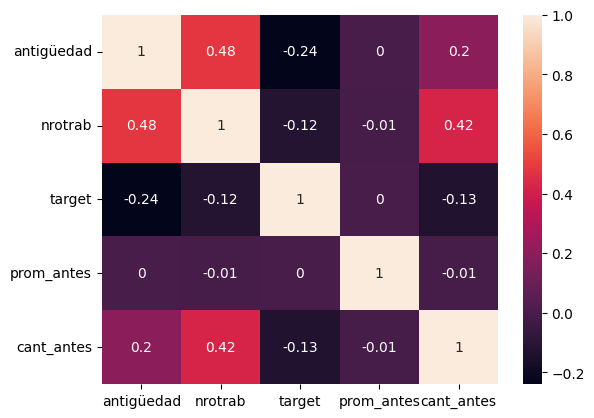

In [7]:
matriz_correlacion = df2.corr().round(2)
sns.heatmap(data=matriz_correlacion, annot=True)


# **Pipeline de transformmación numérica y categórica**

In [8]:
cat_features = X_total.select_dtypes(exclude=["float64", "int64"]).columns.to_list()
numeric_features = X_total.select_dtypes(["float64", "int64"]).columns.to_list()

categorical_transformer = Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('encoder', OneHotEncoder())
            ]
        )    

numeric_transformer = Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]
        )

preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', numeric_transformer, numeric_features),
                ('categorical', categorical_transformer, cat_features),
            ],
    remainder='passthrough'
        )

***Pipeline de XGBoost***


In [9]:

xgb_pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                (
                    "classifier", XGBClassifier(),
                ),
            ]
        )
     

In [10]:

xgb_param_grid = {
    'classifier__learning_rate': np.arange(0.05, 0.5, 0.05),
    'classifier__max_depth': np.arange(2, 10, 1),
    'classifier__n_estimators': np.arange(2, 20, 1),
    'classifier__subsample': np.arange(0.05, 0.5, 0.05)
}

randomized_roc_auc_xgb = RandomizedSearchCV(estimator=xgb_pipeline, 
                                            param_distributions=xgb_param_grid,
                                            n_iter=50,
                                            #scoring='roc_auc',
                                            cv=3, 
                                            verbose=1)

with tf.device('/device:GPU:0'): 
  randomized_roc_auc_xgb.fit(X_train, y_train)

print('Best AUC: ', randomized_roc_auc_xgb.best_score_)
#print('Estimator: ', randomized_roc_auc.best_estimator_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best AUC:  nan


In [11]:
print(randomized_roc_auc_xgb.best_params_)

{'classifier__subsample': 0.4, 'classifier__n_estimators': 9, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.1}


*Classification report de train*

In [12]:
y_pred_train = randomized_roc_auc_xgb.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.67      0.73      0.69       817
         1.0       0.80      0.30      0.43       199
         2.0       0.95      0.98      0.97      7032
         3.0       0.94      0.87      0.91      2484

    accuracy                           0.93     10532
   macro avg       0.84      0.72      0.75     10532
weighted avg       0.93      0.93      0.92     10532



*Classification report de test*

In [13]:
y_pred_test = randomized_roc_auc_xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.64      0.63      0.64       231
         1.0       0.65      0.30      0.41        50
         2.0       0.94      0.98      0.96      1748
         3.0       0.91      0.86      0.88       605

    accuracy                           0.91      2634
   macro avg       0.79      0.69      0.72      2634
weighted avg       0.90      0.91      0.90      2634



***Pipeline de Decision Tree***


In [14]:

dt_pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                (
                    "classifier", DecisionTreeClassifier(),
                ),
            ]
        )

In [15]:

dt_param_grid = {
    'classifier__max_depth': np.arange(3, 10, 1),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_samples_split': np.arange(5, 50, 5)
}

# Perform RandomizedSearchCV
randomized_roc_auc_dt = RandomizedSearchCV(estimator= dt_pipeline, 
                                            param_distributions=dt_param_grid,
                                            n_iter=50,
                                            #scoring='roc_auc',
                                            cv=3, 
                                            verbose=1)

# Fit the estimator
with tf.device('/device:GPU:0'): 
  randomized_roc_auc_dt.fit(X_train, y_train)

# Compute metrics
print('Best AUC: ', randomized_roc_auc_dt.best_score_)
#print('Estimator: ', randomized_roc_auc.best_estimator_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best AUC:  nan


*Classification report de train*

In [16]:
y_pred_train = randomized_roc_auc_dt.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.46      0.46      0.46       817
         1.0       0.85      0.11      0.20       199
         2.0       0.90      0.96      0.93      7032
         3.0       0.90      0.80      0.84      2484

    accuracy                           0.87     10532
   macro avg       0.78      0.58      0.61     10532
weighted avg       0.87      0.87      0.86     10532



*Classification report de test*

In [17]:
y_pred_test = randomized_roc_auc_dt.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.51      0.48      0.50       231
         1.0       0.86      0.12      0.21        50
         2.0       0.90      0.96      0.93      1748
         3.0       0.89      0.80      0.85       605

    accuracy                           0.87      2634
   macro avg       0.79      0.59      0.62      2634
weighted avg       0.86      0.87      0.86      2634



# **Ajuste de modelo seleccionado**

In [18]:
X_total[['antigüedad', 'nrotrab', 'prom_antes', 'cant_antes']] = StandardScaler().fit_transform(X_total[['antigüedad', 'nrotrab', 'prom_antes', 'cant_antes']])
X_numeric = X_total[['antigüedad', 'nrotrab', 'prom_antes', 'cant_antes']]
X_numeric =  X_numeric.reset_index(drop=True)

In [19]:
ACTECON_dummies = pd.get_dummies(X_total['ACTECON'], prefix='').reset_index(drop=True)
GRUANALI_dummies = pd.get_dummies(X_total['GRUANALI'], prefix='').reset_index(drop=True)
TAMAEMP_dummies = pd.get_dummies(X_total['TAMAEMP'], prefix='').reset_index(drop=True)
riesgo_dummies = pd.get_dummies(X_total['riesgo'], prefix='').reset_index(drop=True)
categoria_dummies = pd.get_dummies(X_total['categoria'], prefix='').reset_index(drop=True)
modular_dummies = pd.get_dummies(X_total['modular'], prefix='').reset_index(drop=True)
X_base = X_total[['ACTECON']]

In [20]:
X_base = pd.concat([X_base.reset_index(drop=True), ACTECON_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), GRUANALI_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), TAMAEMP_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), riesgo_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), categoria_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), modular_dummies], axis=1)
X_base = pd.DataFrame(X_base)
X_base = X_base.drop(['ACTECON'], axis=1)
X_base

,_ACT_ECON_1,_ACT_ECON_10,_ACT_ECON_11,_ACT_ECON_12,_ACT_ECON_13,_ACT_ECON_14,_ACT_ECON_15,_ACT_ECON_16,_ACT_ECON_17,_ACT_ECON_18,...,_CATEGORIA__1,_CATEGORIA__2,_CATEGORIA__3,_CATEGORIA__4,_CATEGORIA__5,_CATEGORIA__6,_CATEGORIA__7,_MODULAR__0,_MODULAR__1,_MODULAR__2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
13164,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [21]:
X_model = pd.concat([X_base.reset_index(drop=True), X_numeric], axis=1)
X_model = pd.DataFrame(X_model)
X_model

,_ACT_ECON_1,_ACT_ECON_10,_ACT_ECON_11,_ACT_ECON_12,_ACT_ECON_13,_ACT_ECON_14,_ACT_ECON_15,_ACT_ECON_16,_ACT_ECON_17,_ACT_ECON_18,...,_CATEGORIA__5,_CATEGORIA__6,_CATEGORIA__7,_MODULAR__0,_MODULAR__1,_MODULAR__2,antigüedad,nrotrab,prom_antes,cant_antes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.681729,-0.781544,-0.020294,-0.836513
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.010954,-0.835724
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.020294,-0.836513
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.001765,-0.834934
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.017268,-0.830985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.681729,-0.757704,0.166318,-0.834934
13162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.681729,-0.757704,0.023318,-0.835724
13163,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,-0.849109,-0.603628,-0.019067,-0.835724
13164,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.402762,-0.781544,-0.018356,-0.834934


<Axes: >

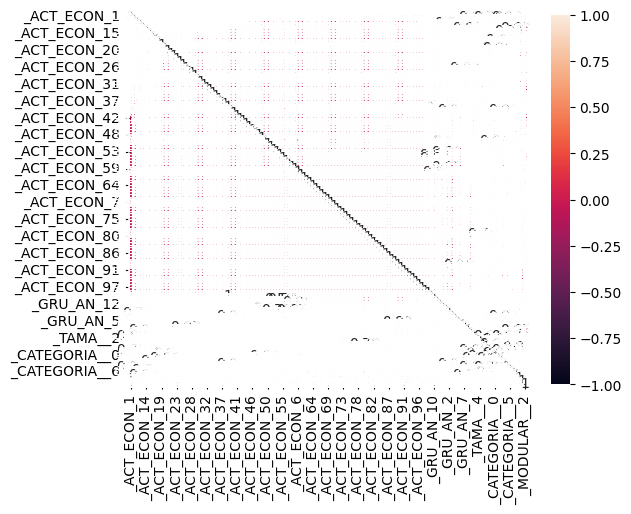

In [22]:
matriz_correlacion = X_base.corr().round(2)
sns.heatmap(data=matriz_correlacion, annot=True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_model, Y_total, test_size=0.2, random_state=2022)

In [24]:
xgb_selecc = xgb.XGBClassifier(nthread=3, #when use hyperthread, xgboost may become slower
         objective='multi:softprob',
         learning_rate= 0.4, #so called `eta` value
         max_depth= 6,
         n_estimators = 3,
         subsample= 0.45,
         seed = 2022)


In [25]:
xgb_selecc.fit(X_train,
         y_train,  
         eval_metric="merror",
         early_stopping_rounds=50,
         eval_set = [(X_train, y_train),(X_test, y_test)])

[0]	validation_0-merror:0.10919	validation_1-merror:0.11769
[1]	validation_0-merror:0.09457	validation_1-merror:0.11162
[2]	validation_0-merror:0.09058	validation_1-merror:0.10592


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=3, n_jobs=None, nthread=3, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [26]:
y_pred_train = xgb_selecc.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62       817
         1.0       0.73      0.29      0.41       199
         2.0       0.94      0.98      0.96      7032
         3.0       0.94      0.85      0.89      2484

    accuracy                           0.91     10532
   macro avg       0.81      0.69      0.72     10532
weighted avg       0.91      0.91      0.91     10532



In [27]:
y_pred_test = xgb_selecc.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.62      0.55      0.59       231
         1.0       0.81      0.26      0.39        50
         2.0       0.92      0.98      0.95      1748
         3.0       0.91      0.83      0.87       605

    accuracy                           0.89      2634
   macro avg       0.82      0.66      0.70      2634
weighted avg       0.89      0.89      0.89      2634



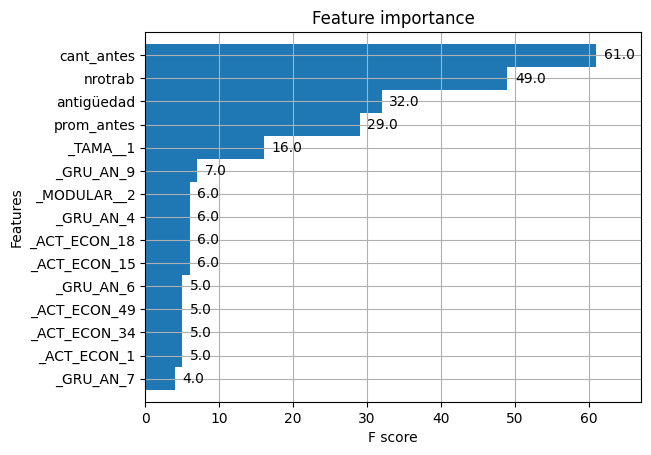

In [28]:
plot_importance(xgb_selecc, height = 1, max_num_features = 15)
pyplot.show()